In [2]:
from pathlib import Path
from typing import List, Dict, Optional

# Test numpy import first
import numpy as np
print(f"NumPy version: {np.__version__}")

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# MVTec classes (one-class setup per run)
MVTEC_CLASSES = [
    "bottle","cable","capsule","carpet","grid","hazelnut","leather","metal_nut",
    "pill","screw","tile","toothbrush","transistor","wood","zipper"
]

# ImageNet normalization for pretrained backbones later
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# valid extensions
IMG_EXTS = {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}

NumPy version: 1.26.4


In [3]:
class MvtecAD(Dataset):
    """
    root/
      class_name/
        train/good/*.png|jpg
        test/defect_type/*.png|jpg
        ground_truth/defect_type/*_mask.png
    """
    def __init__(
        self,
        root: str,
        cls_name: str,
        split: str = "train",
        image_size: int = 256,
        augment_train: bool = True,
    ):
        assert cls_name in MVTEC_CLASSES, f"Unknown class: {cls_name}"
        assert split in ["train", "test"]
        self.root = Path(root)
        self.cls_name = cls_name
        self.split = split
        self.image_size = image_size

        # image transforms
        self.img_tfms_train = transforms.Compose([
            transforms.Resize((image_size, image_size), interpolation=Image.BILINEAR),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
        self.img_tfms_eval = transforms.Compose([
            transforms.Resize((image_size, image_size), interpolation=Image.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])

        self.img_tfms = self.img_tfms_train if (split == "train" and augment_train) else self.img_tfms_eval

        # mask transforms (NEAREST to keep edges crisp)
        self.mask_tfms = transforms.Compose([
            transforms.Resize((image_size, image_size), interpolation=Image.NEAREST),
            transforms.PILToTensor(),  # -> [1,H,W] uint8 0..255
        ])

        self.samples = self._gather_samples()
        if len(self.samples) == 0:
            raise RuntimeError(f"No samples found for class '{cls_name}' split '{split}'. "
                               f"Check your 'root' path: {self.root}")

    def _is_img(self, p: Path) -> bool:
        return p.suffix.lower() in IMG_EXTS

    def _gather_samples(self) -> List[Dict]:
        cls_dir = self.root / self.cls_name
        split_dir = cls_dir / self.split

        pairs: List[Dict] = []
        if self.split == "train":
            img_dir = split_dir / "good"
            if not img_dir.exists():
                return []
            for p in sorted(img_dir.rglob("*")):
                if self._is_img(p):
                    pairs.append({"img": p, "mask": None, "label": 0})
        else:
            if not split_dir.exists():
                return []
            for defect_dir in sorted([d for d in split_dir.iterdir() if d.is_dir()]):
                defect_name = defect_dir.name  # e.g., good, broken_small, etc.
                for p in sorted(defect_dir.rglob("*")):
                    if not self._is_img(p):
                        continue
                    if defect_name == "good":
                        mask_path = None
                        label = 0
                    else:
                        mask_dir = cls_dir / "ground_truth" / defect_name
                        mask_name = p.stem + "_mask.png"
                        mask_path = mask_dir / mask_name
                        label = 1
                    pairs.append({"img": p, "mask": mask_path, "label": label})
        return pairs

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        item = self.samples[idx]

        # image
        img = Image.open(item["img"]).convert("RGB")
        x = self.img_tfms(img)  # [3,H,W] float32

        # label: 0 normal / 1 anomaly
        y = torch.tensor(item["label"], dtype=torch.long)

        # mask (only test defects have masks)
        if self.split == "test" and (item["mask"] is not None) and item["mask"].exists():
            mask = Image.open(item["mask"]).convert("L")
            m = self.mask_tfms(mask)                  # [1,H,W] uint8 (0..255)
            m = (m > 127).to(torch.uint8)             # binarize to {0,1}
        else:
            # placeholder zeros for train/good
            m = torch.zeros((1, x.shape[1], x.shape[2]), dtype=torch.uint8)

        return {
            "image": x,            # float32 normalized
            "mask": m,             # uint8 {0,1}
            "is_anomaly": y,       # 0/1
            "path": str(item["img"])
        }


In [4]:
def build_mvtec_loaders(
    root: str,
    cls_name: str,
    image_size: int = 256,
    batch_size: int = 32,
    num_workers: int = 2,
    augment_train: bool = True
):
    ds_train = MvtecAD(root, cls_name, split="train", image_size=image_size, augment_train=augment_train)
    ds_test  = MvtecAD(root, cls_name, split="test",  image_size=image_size, augment_train=False)

    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True, drop_last=True)
    dl_test  = DataLoader(ds_test, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
    return ds_train, ds_test, dl_train, dl_test


In [5]:
root = "mvtec_anomaly_detection"
cls  = "bottle"        

ds_train, ds_test, dl_train, dl_test = build_mvtec_loaders(
    root=root,
    cls_name=cls,
    image_size=256,
    batch_size=8,  # Reduced batch size for training
    num_workers=0,  # Set to 0 to avoid multiprocessing issues on Windows
    augment_train=True
)

print(f"Train samples: {len(ds_train)} | Test samples: {len(ds_test)}")

Train samples: 209 | Test samples: 83


In [6]:

batch = next(iter(dl_train))
print("Train batch image:", batch["image"].shape)   # [B,3,256,256]
print("Train batch mask :", batch["mask"].shape)    # [B,1,256,256] (zeros in train)
print("Train labels     :", batch["is_anomaly"])    # all zeros

batch_test = next(iter(dl_test))
print("Test batch image :", batch_test["image"].shape)
print("Test batch mask  :", batch_test["mask"].shape)
print("Test labels      :", batch_test["is_anomaly"][:8])
print("Sample path      :", batch_test["path"][0])


Train batch image: torch.Size([8, 3, 256, 256])
Train batch mask : torch.Size([8, 1, 256, 256])
Train labels     : tensor([0, 0, 0, 0, 0, 0, 0, 0])
Test batch image : torch.Size([8, 3, 256, 256])
Test batch mask  : torch.Size([8, 1, 256, 256])
Test labels      : tensor([1, 1, 1, 1, 1, 1, 1, 1])
Sample path      : mvtec_anomaly_detection\bottle\test\broken_large\000.png
Test batch image : torch.Size([8, 3, 256, 256])
Test batch mask  : torch.Size([8, 1, 256, 256])
Test labels      : tensor([1, 1, 1, 1, 1, 1, 1, 1])
Sample path      : mvtec_anomaly_detection\bottle\test\broken_large\000.png


In [7]:
import torch.nn.functional as F

def denorm(x: torch.Tensor):
    """ x: [3,H,W] normalized -> [H,W,3] in [0,1] """
    mean = torch.tensor(IMAGENET_MEAN, device=x.device).view(3,1,1)
    std  = torch.tensor(IMAGENET_STD,  device=x.device).view(3,1,1)
    y = x * std + mean
    return y.clamp(0,1).permute(1,2,0).cpu().numpy()

def show_batch_with_masks(batch, max_n=6, title=""):
    imgs = batch["image"]
    masks = batch["mask"].float()
    labels = batch["is_anomaly"]
    n = min(max_n, imgs.size(0))
    plt.figure(figsize=(12, 2*n))
    for i in range(n):
        img = denorm(imgs[i])
        m   = masks[i][0].cpu().numpy()  # [H,W]
        # plot image
        plt.subplot(n, 2, 2*i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"img  (label={int(labels[i].item())})")
        # plot mask
        plt.subplot(n, 2, 2*i+2)
        plt.imshow(m, cmap="gray")
        plt.axis("off")
        plt.title("mask")
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


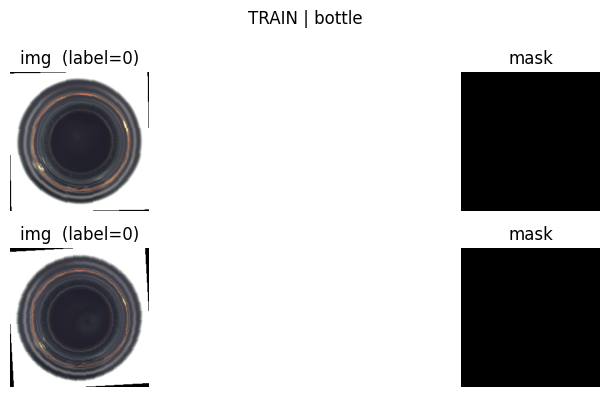

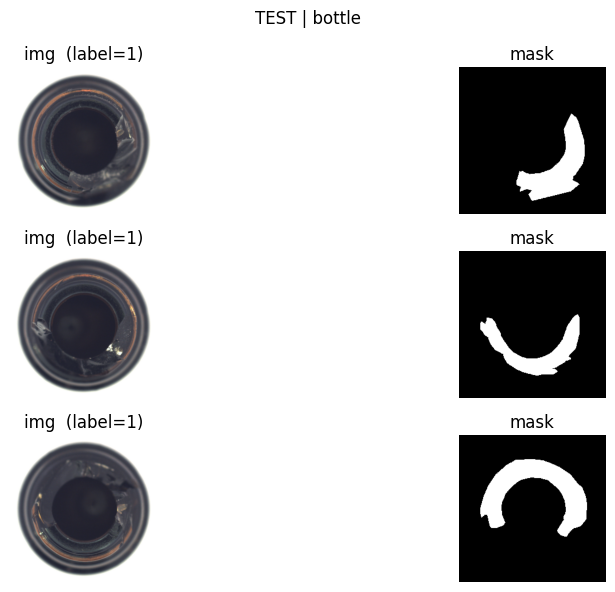

In [8]:
# Train (should be all normal; masks are zero)
train_batch = next(iter(dl_train))
show_batch_with_masks(train_batch, max_n=2, title=f"TRAIN | {cls}")

# Test (mix of good/defects; masks only for defects)
test_batch = next(iter(dl_test))
show_batch_with_masks(test_batch, max_n=3, title=f"TEST | {cls}")


In [9]:
# Count how many test items actually have masks (i.e., defective)
has_mask = 0
for s in ds_test.samples:
    if s["label"] == 1 and s["mask"] is not None and s["mask"].exists():
        has_mask += 1
print(f"Defective test items with masks: {has_mask}")

# Verify all train labels are 0
assert all(s["label"] == 0 for s in ds_train.samples), "Found non-normal item in train split!"
print("Train split is clean (all good). ✅")


Defective test items with masks: 63
Train split is clean (all good). ✅
